Drive Connection

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Mounted at / content / drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install earthpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import Required Libraries

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import folium
import os, shutil
import glob
import cv2
import gdal
from osgeo import gdal
import rasterio
from skimage import data, color
from skimage.transform import rescale, resize
from skimage import io, transform, exposure
from matplotlib.pyplot import imread, imshow, show, subplot, title, get_cmap, hist
from skimage.exposure import equalize_hist
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import rasterio as rio

RGB bant Stacking

In [ ]:
path = '/content/drive/MyDrive/LC09_L1TP_180032_20211111_20220119_02_T1_B'
b2 = io.imread(path+'2.TIF') #b
b3 = io.imread(path+'3.TIF') #g
b4 = io.imread(path+'4.TIF') #r

In [ ]:
# Create an RGB image using numpy arrays
img_rgb=np.dstack((b4,b3,b2))

R-G-B Bands

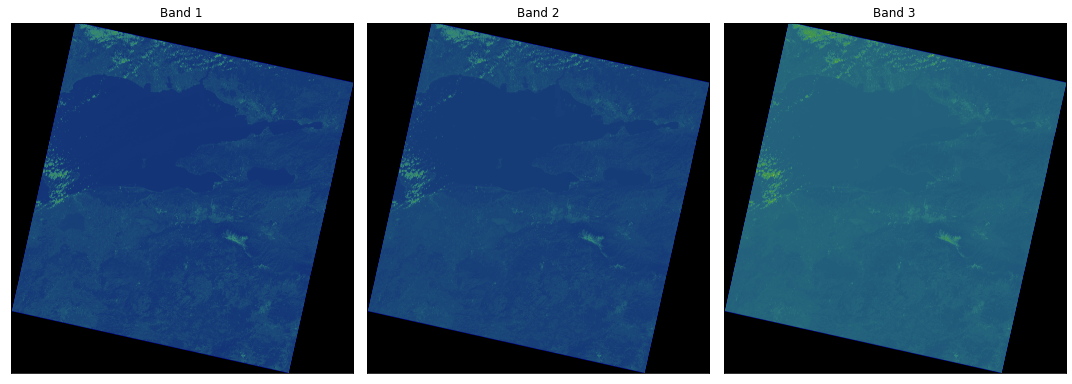

In [ ]:
ep.plot_bands(img_rgb, 
              cmap = 'gist_earth', 
              figsize = (15,15), 
              cols = 3,
              cbar = False)
plt.show()

RGB image showing and saving (Saved TIF file type is uint8)

In [ ]:
# Define a function to show the numpy array as true colour image
def color_image_show(low_pct=5, high_pct=96, size=15):
    # Adjust the intensity of the image
    p2, p98 = np.percentile(img_rgb, (low_pct, high_pct))
    img_exp = exposure.rescale_intensity(img_rgb, in_range=(p2, p98))
    # Plot
    fig = plt.figure(figsize=(size, size))
    plt.imshow(img_exp/65535)
    return plt.show()

In [ ]:
# Adjust the intensity of the image
p2, p98 = np.percentile(img_rgb, (5, 95))
img_exp = exposure.rescale_intensity(img_rgb, in_range=(p2, p98))
# Save image to file
io.imsave('/content/drive/MyDrive/RGB.TIF', img_exp)

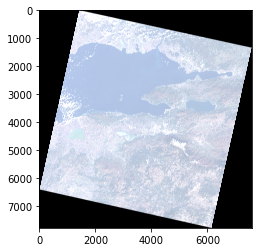

In [ ]:
plt.imshow(img_exp/65535)

Import RGB image and Crop

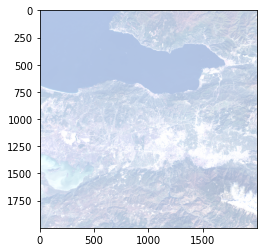

In [ ]:
img_path = '/content/drive/MyDrive/RGB.TIF'
img = plt.imread(img_path)
imgCropped =img[3000:5000,3000:5000]
fig = plt.figure(0)
plt.imshow(imgCropped)
plt.show()

In [ ]:
! pip install image_dehazer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 5.2 MB/s 
  Created wheel for image-dehazer: filename=image_dehazer-0.0.5-py3-none-any.whl size=5338 sha256=5616659375d0f196a847ccf4687f73522fe3b98b8ef9149aa6aeb4b136c1e432
  Stored in directory: /root/.cache/pip/wheels/1f/df/91/5f397926c032bd3a2f67bf771bfa1c555e67fe8877814c926e
Successfully built image-dehazer
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.0 which is incompatible.
tensorflow 2.8.2+zzzcolab20220719082949 requires numpy>=1.20, but you have numpy 1.19.0 which is incompatible.
cmdstanpy 

Image Dehazing

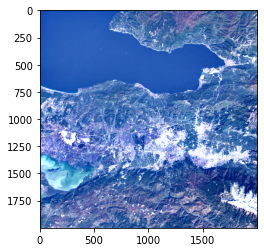

In [ ]:
import image_dehazer										# Load the library
HazeCorrectedImg = image_dehazer.remove_haze(imgCropped)		# Remove Haze
plt.imshow(HazeCorrectedImg)		# display the result

Histogram & Histogram Equalize

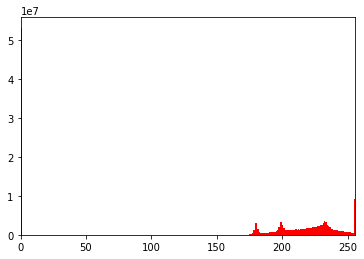

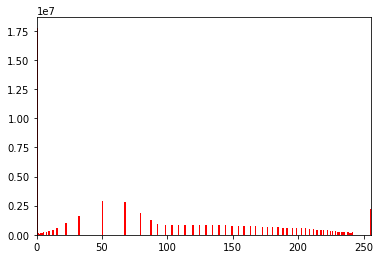

In [ ]:
grayimg=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
equ = cv2.equalizeHist(grayimg)
hist,bins = np.histogram(img.flatten(),256,[0,256])
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.show()
hist,bins = np.histogram(equ.flatten(),256,[0,256])
plt.hist(equ.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.show()

/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


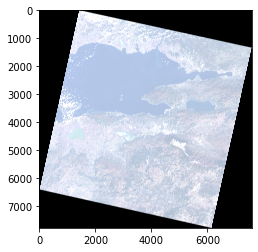

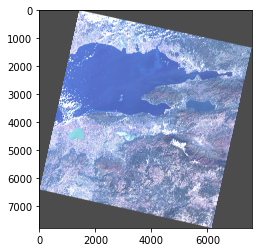

In [ ]:
eq = equalize_hist(img)
plt.imshow(img)
plt.show()
plt.imshow(eq)
plt.show()

Pan band import-resize-crop

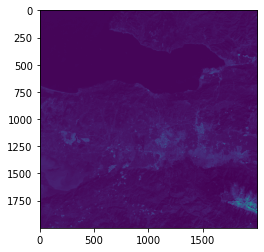

In [ ]:
panBand = io.imread('/content/drive/MyDrive/LC09_L1TP_180032_20211111_20220119_02_T1_B8.TIF')

image_rescaled = rescale(panBand, 0.50, anti_aliasing=False)
image_resized = resize(image_rescaled, (7761,7581),
                       anti_aliasing=True)
panCropped =image_resized[3000:5000,3000:5000]
plt.show()
plt.imshow(panCropped)

img =img[3000:5000,3000:5000]

pansharping

<Figure size 432x288 with 0 Axes>

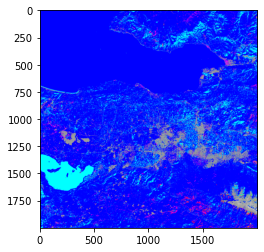

In [ ]:
pan = panCropped
m= img
method = 'esri'
W = 0.1

# rgbn_scaled = np.empty((img_rgbn.shape[0]*4, img_rgbn.shape[1]*4, 4))
output_image =  np.empty((m.shape[0], m.shape[1], 3))

R = m[:,:,0] # red
G = m[:,:,1] # green
B = m[:,:,2] # blue
# NIR = m[:,:,3] # nir

rgbn_scaled = m

if method == 'simple_browley':
    sum = R+G+B 
    for band in range(rgbn_scaled.shape[2]): #3
      output_image[:, :, band] = np.multiply(rgbn_scaled[:, :, band], (pan / sum))

if method == 'esri':
  ADJ = pan-rgbn_scaled.mean(axis=2) 
  for band in range(rgbn_scaled.shape[2]):
    output_image[:, :, band] = rgbn_scaled[:, :, band] + ADJ

if method == 'browley':
  DNF = (pan - W)/(W*R+W*G+W*B)
  for band in range(rgbn_scaled.shape[2]):
    output_image[:, :, band] = rgbn_scaled[:, :, band] * DNF

if method == 'hsv':
  hsv = color.rgb2hsv(rgbn_scaled[:,:,:3])
  hsv[:,:,2] = pan - W
  output_image = color.hsv2rgb(hsv)

output_image = output_image - np.nanpercentile(output_image, 2)/ (np.nanpercentile(output_image, 98) - np.nanpercentile(output_image,2))

plt.figure()
plt.show()
plt.imshow(output_image)

(-0.5, 1999.5, 1999.5, -0.5)

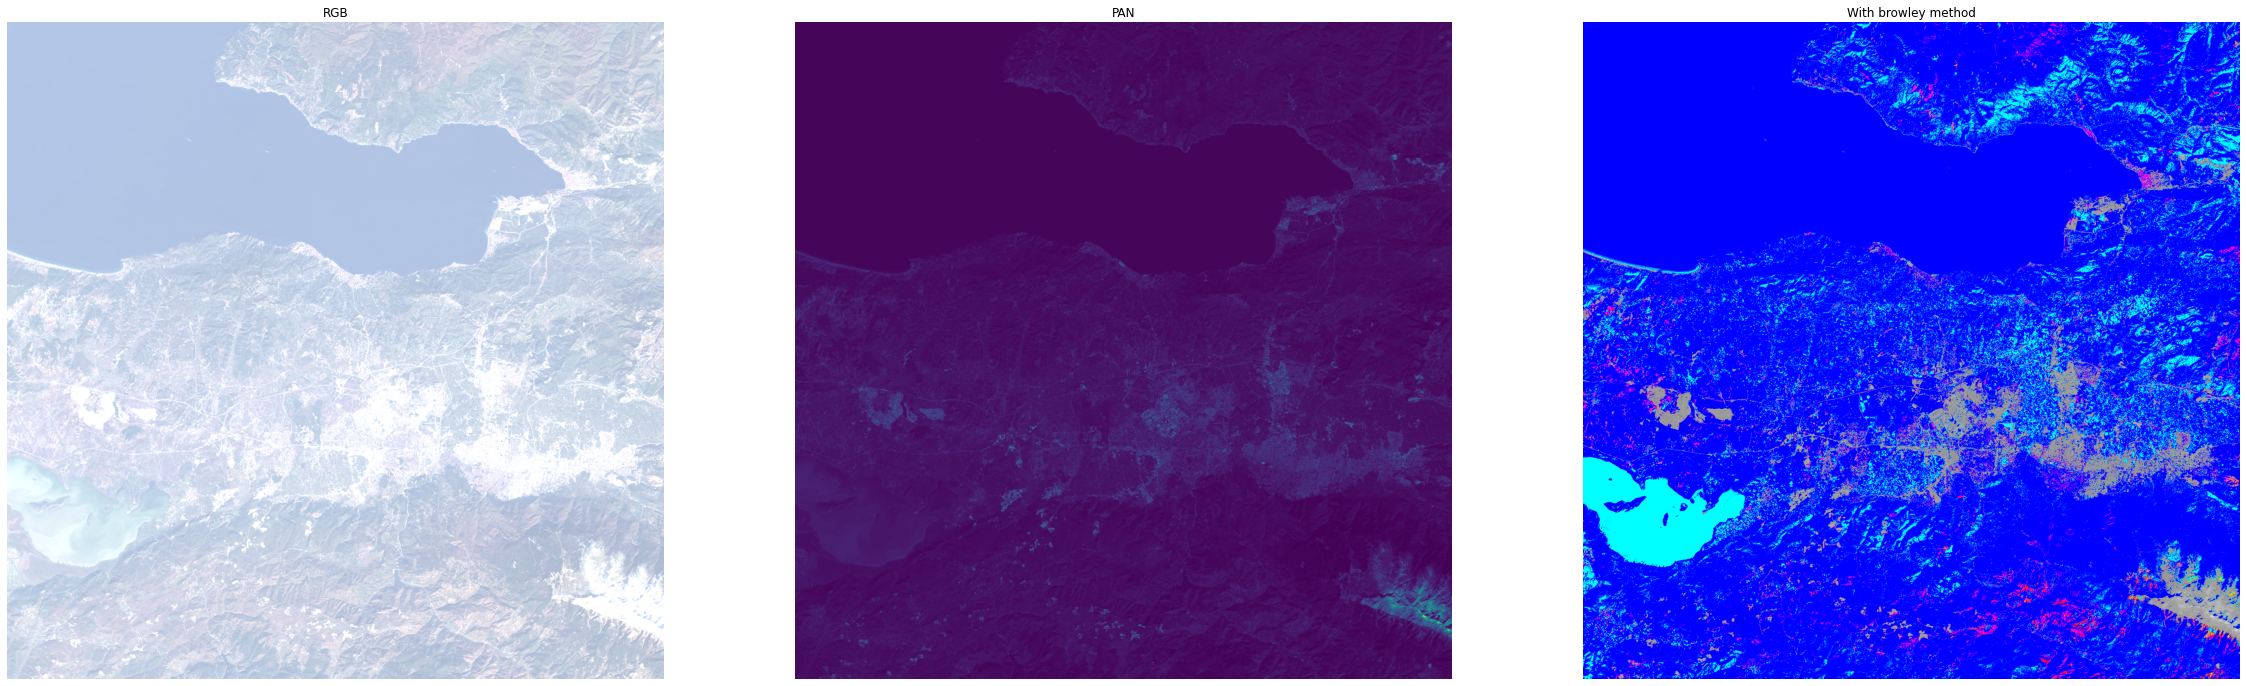

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(40, 40))
ax[0].imshow(img[:,:,:])
ax[0].set_title('RGB')
ax[0].axis('off')

ax[1].imshow(panCropped[:,:])
ax[1].set_title('PAN')
ax[1].axis('off')

ax[2].imshow(output_image[:,:,:3])
ax[2].set_title('With browley method')
ax[2].axis('off')

